In [55]:
## D7041E project by Sebastian Lindgren

In [56]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from keras.datasets import mnist
from collections import OrderedDict
from torch.utils.data import TensorDataset, DataLoader
from ipywidgets import IntProgress
from IPython.display import display
from random import randint

In [57]:
# Test if cuda is working
if torch.cuda.is_available():
    print("CUDA is available. GPU is available for use.")
else:
    print("CUDA is not available. Using CPU instead.")

CUDA is available. GPU is available for use.


In [58]:
# Load minst dataset
(Xtr, Ltr), (X_test, L_test)=mnist.load_data()

# Choose training and test data
num_sample_training=20000
num_sample_testing=5000
X_training=Xtr[:num_sample_training,:,:]
L_training=Ltr[:num_sample_training]
X_test=X_test[:num_sample_testing,:,:]
L_test=L_test[:num_sample_testing]

img_shape = Xtr.shape[1]*Xtr.shape[2]
norm_value = 255

# Flatten to 1D array and normalize data
X_training=X_training.reshape(num_sample_training, img_shape) / norm_value
X_test=X_test.reshape(num_sample_testing, img_shape) / norm_value

# USe GPU instead of CPU to process faster
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to tensor and move GPU if it's available
X_training = torch.tensor(X_training, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
L_training = torch.tensor(L_training).long().to(device)  
L_test = torch.tensor(L_test).long().to(device)

train_dataset = TensorDataset(X_training, L_training)
test_dataset = TensorDataset(X_test, L_test)

batch_size = 64

# Shuffle the trainingdata
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f"Using {X_training.shape[0]} training samples and {X_test.shape[0]} test samples")

Using 20000 training samples and 5000 test samples


In [59]:

class MLP(nn.Module):
    def __init__(self, hidden_layers, start_neurons) -> None:
        super(MLP, self).__init__()
        
        layers_list = [('input', nn.Linear(784, start_neurons)), ('input_act', nn.ReLU())]

        # Add the specified number of hidden layers
        neurons = start_neurons
        for i in range(hidden_layers):
            out_neurons = neurons//2 if neurons >= 20 else neurons
            layers_list.append((f'dense{i+1}', nn.Linear(neurons, out_neurons))) 
            layers_list.append((f'act{i+1}', nn.ReLU())) 
            neurons = out_neurons
      
        layers_list.append(('output', nn.Linear(neurons, 10)))  
        
        self.model_layers = OrderedDict(layers_list)

        self.model = nn.Sequential(self.model_layers)

    def forward(self, x):
        return self.model(x)


    def train_model(self, train_loader, num_epochs, optimizer , loss_fn=nn.CrossEntropyLoss()):
        self.train()  # Set the model to training mode

        for epoch in range(num_epochs):
            running_loss = 0
            for images, labels in train_loader:
                # Move data and labels to the same device as the model
                images, labels = images.to(device), labels.to(device)
    
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = self(images)
                loss = loss_fn(outputs, labels)
                
                
                # Backward and optimize
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            
            # Print statistics
            #print(f"Epoch {epoch+1}/{num_epochs}.. "
                  #f"Train loss: {running_loss/len(train_loader):.3f}")

    def test_model(self, test_loader, loss_fn=nn.CrossEntropyLoss()):
        self.eval()  

        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():  # No need to track gradients while testing, this makes it faster
            for images, labels in test_loader:
               
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = self(images)
                test_loss += loss_fn(outputs, labels).item()
                

                # Get the predicted class from the maximum value in the output-list of class scores
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        
        avg_loss = test_loss / len(test_loader)
        accuracy = correct / total
        #print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')
        return accuracy


 


In [60]:
# # Train and test model
# starting_neurons_list = [32, 64, 256, 512, 1024]
# hidden_layers_list = [1, 2, 3, 4, 5]
# epochs_list = [ 10, 20, 50, 70]
# hidden_layers = 1
# starting_neurons = 256
# epochs = 10

# model = MLP(hidden_layers=hidden_layers, start_neurons=starting_neurons).to(device)
# print(f"This is the current model: {model}")
# loss_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# model.train_model(train_loader=train_loader, num_epochs=epochs, loss_fn=loss_fn, optimizer=optimizer)

# accuracy = model.test_model(test_loader=test_loader, loss_fn=loss_fn)



In [61]:
# Test hyperparameters with different optimizers


optimizer_configs = [
    ("SGD", {"lr": 0.01, "momentum" :0.9} ),
    ("Adam", {"lr": 0.001}),
    ("RMSprop", {"lr": 0.001}),
]

starting_neurons_list = [32, 64, 256, 512]
hidden_layers_list = [1, 2, 3, 4]
epochs_list = [5, 10, 40, 70]


best_results = {
    "optimizer_name": "",
    "accuracy": 0,
    "neurons": 0,
    "layers": 0,
    "epochs": 0
}

# Progressbar
max_count = len(epochs_list) * len(starting_neurons_list) * len(hidden_layers_list)
progress = IntProgress(value=0, min=0, max=max_count)  
display(progress) 
current_count = 0
best_accuracy = 0

test_details = []

# Save models to a folder called Models in current working directory
current_working_directory = os.getcwd()
models_dir = os.path.join(current_working_directory, 'Models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)


for epoch in epochs_list:
    for neuron in starting_neurons_list:
        for layers in hidden_layers_list:
            for optimizer_name, config in optimizer_configs:
                current_count += 1
                progress.value = current_count
            
                model = MLP(hidden_layers=layers, start_neurons=neuron).to(device)
                # print("***********************************************************************************************************")
                # print(f"Starting training and testing with starting neurons: {neuron}, hidden layers: {layers} and {epoch} epochs.")
                # print(f"This is the current model: {model}")
                
                if optimizer_name == "SGD":
                    optimizer = torch.optim.SGD(model.parameters(), **config)
                elif optimizer_name == "Adam":
                    optimizer = torch.optim.Adam(model.parameters(), **config)
                elif optimizer_name == "RMSprop":
                    optimizer = torch.optim.RMSprop(model.parameters(), **config)

                loss_fn = nn.CrossEntropyLoss()

                model.train_model(train_loader=train_loader, num_epochs=epoch, loss_fn=loss_fn, optimizer=optimizer)

                current_accuracy = model.test_model(test_loader=test_loader, loss_fn=loss_fn)

                # Save model to a file
                model_name = f"model_opt{optimizer_name}_ep{epoch}_neu{neuron}_lay{layers}_acc{current_accuracy:.4f}.pth"
                model_path = os.path.join(models_dir, model_name)
                torch.save(model.state_dict(), model_path)

                # Store all test data
                test_details.append({
                    "optimizer": optimizer_name,
                    "accuracy": current_accuracy,
                    "neurons": neuron,
                    "layers": layers,
                    "epochs": epoch
                })

                
                if current_accuracy > best_accuracy:
                    best_accuracy = current_accuracy
                    best_results['optimizer_name'] = optimizer_name
                    best_results["accuracy"] = current_accuracy
                    best_results["neurons"] = neuron
                    best_results["layers"] = layers
                    best_results["epochs"] = epoch
                        
test_details = sorted(test_details, key=lambda x: x['accuracy'], reverse=True)
print(f"The best accuracy: {best_results['accuracy']}. It was achieved with the following hyperparmeters: \n {best_results['epochs']} epochs. \n {best_results['neurons']} starting neurons. \n {best_results['layers']} layers. \n {best_results['optimizer_name']} as optimizer. ")
for details in test_details:
    print(f"Epochs: {details['epochs']}, Layers: {details['layers']}, Neurons: {details['neurons']}, Accuracy: {details['accuracy']}, Optimizer: {details['optimizer']} ")                    

IntProgress(value=0, max=64)

The best accuracy: 0.9724. It was achieved with the following hyperparmeters: 
 70 epochs. 
 512 starting neurons. 
 2 layers. 
 Adam as optimizer. 
Epochs: 70, Layers: 2, Neurons: 512, Accuracy: 0.9724, Optimizer: Adam 
Epochs: 70, Layers: 3, Neurons: 512, Accuracy: 0.9694, Optimizer: Adam 
Epochs: 40, Layers: 2, Neurons: 512, Accuracy: 0.969, Optimizer: Adam 
Epochs: 40, Layers: 1, Neurons: 256, Accuracy: 0.9682, Optimizer: Adam 
Epochs: 40, Layers: 2, Neurons: 256, Accuracy: 0.9678, Optimizer: Adam 
Epochs: 70, Layers: 1, Neurons: 256, Accuracy: 0.9676, Optimizer: RMSprop 
Epochs: 70, Layers: 4, Neurons: 512, Accuracy: 0.9674, Optimizer: RMSprop 
Epochs: 70, Layers: 2, Neurons: 256, Accuracy: 0.9672, Optimizer: Adam 
Epochs: 70, Layers: 1, Neurons: 512, Accuracy: 0.9672, Optimizer: Adam 
Epochs: 70, Layers: 2, Neurons: 512, Accuracy: 0.9672, Optimizer: RMSprop 
Epochs: 40, Layers: 3, Neurons: 256, Accuracy: 0.9668, Optimizer: RMSprop 
Epochs: 70, Layers: 1, Neurons: 256, Accuracy: 0

In [62]:
# Preprocces single images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def pre_process_image(image, img_shape=(-1, 28*28), norm_value=255.0):
    # Flatten image to 1D array and normalize
    image=image.reshape(img_shape) / norm_value

    # Convert to tensor and set to gpu
    image = torch.tensor(image, dtype=torch.float32).to(device)

    return image
 

# Display image

def display_image(image, label):
    plt.title( f"Label is {label}")
    plt.imshow(image)

    plt.show()
    plt.close()
    


Prediction: 4


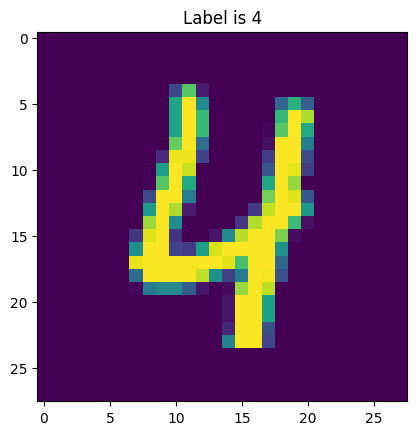

In [93]:
# Demo


# Load minst dataset
(Xtr, Ltr), (X_test, L_test)=mnist.load_data()
random_nr = randint(0, 1000)
image = X_test[random_nr,:,:]
label = L_test[random_nr]
image_preprocessed = pre_process_image(image)

# # Load the best saved model from Model folder
# current_working_directory = os.getcwd()
# model_name = "model_optAdam_ep70_neu512_lay2_acc0.9724.pth"
# model_path = os.path.join(current_working_directory, 'Models', model_name)
# model = MLP(hidden_layers=2, start_neurons=512)  
# model.load_state_dict(torch.load(model_path)) 

# Load the best saved model 
model_name = "model_optAdam_ep70_neu512_lay2_acc0.9724.pth"
model = MLP(hidden_layers=2, start_neurons=512)  
model.load_state_dict(torch.load(model_name)) 

# Test random data 
model.eval()
model.to(device)
output=model(image_preprocessed)
predicted_class = output.argmax(dim=1)
print(f"Prediction: {predicted_class.item()}")
display_image(image, label)









## Conclusion

The five best models all used Adam as optimization function. The accuracy for the best five is in the range (96,78-97.24) which means they are pretty close to eachother. The best three all used 512 neurons which is the highest I tested. Besides from that the top results was all trained with either 40 or 70 epochs and had one, two or three hidden layers. At 6th place is the first RMSprop-result with 96,76% accuracy. It used only one hidden layer, 70 epochs and 256 neurons. We have to go to the 14th best result to find the first SGD with an accuracy of 96.6%. It was trained by 70 epochs and used 512 neurons but only had one hidden layer aswell. The top four results for the SGD used either one or two hidden layers. <br>

To summarize this, Adam was the best optimizer for this task but it was pretty close with the others. The most important parameter seems to be the number of neurons used and to get atleast 40 epochs of training. The number of hidden layers seems the least important but it never seems necessary to have more than three layers.